In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = 2bd1f75
conc = None
dv = 0.01
klin = 0
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 100
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 294
vmax = 1380
vmin = 1215
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

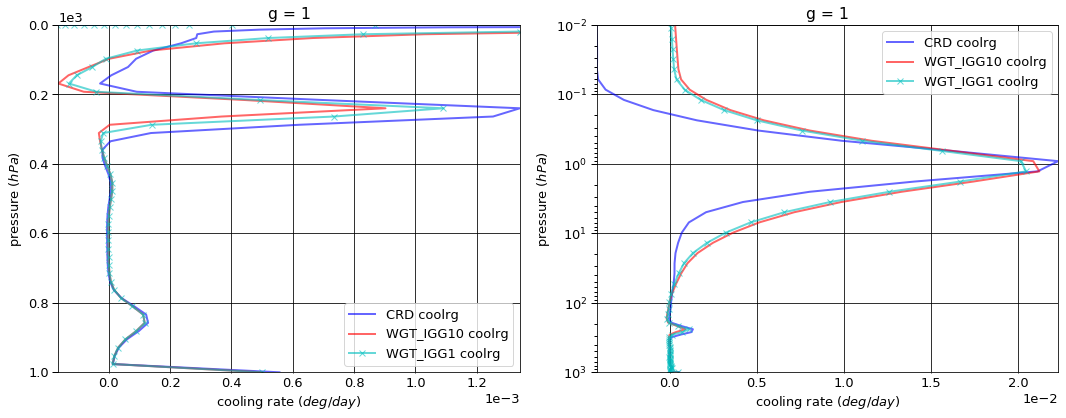

# Figure: cooling rate g-group 2

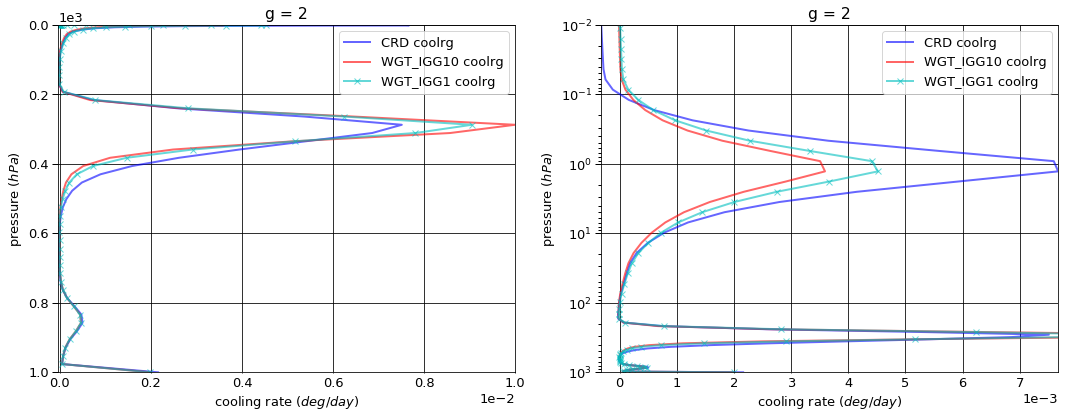

# Figure: cooling rate g-group 3

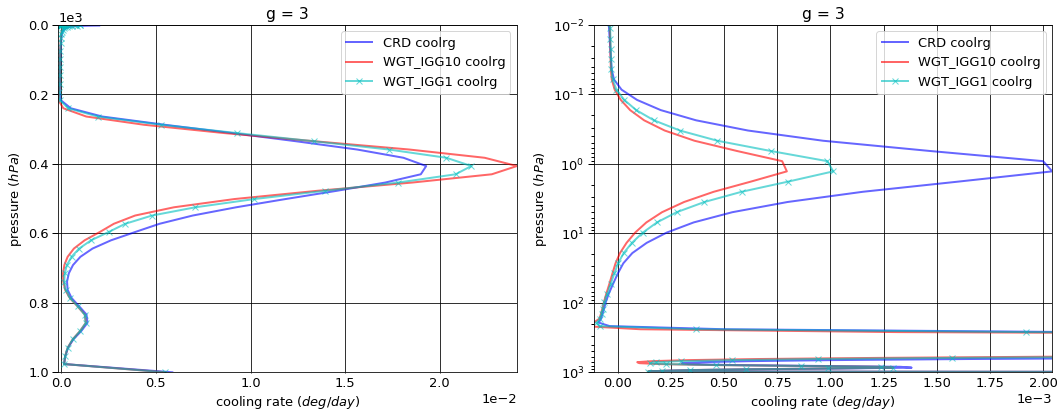

# Figure: cooling rate g-group 4

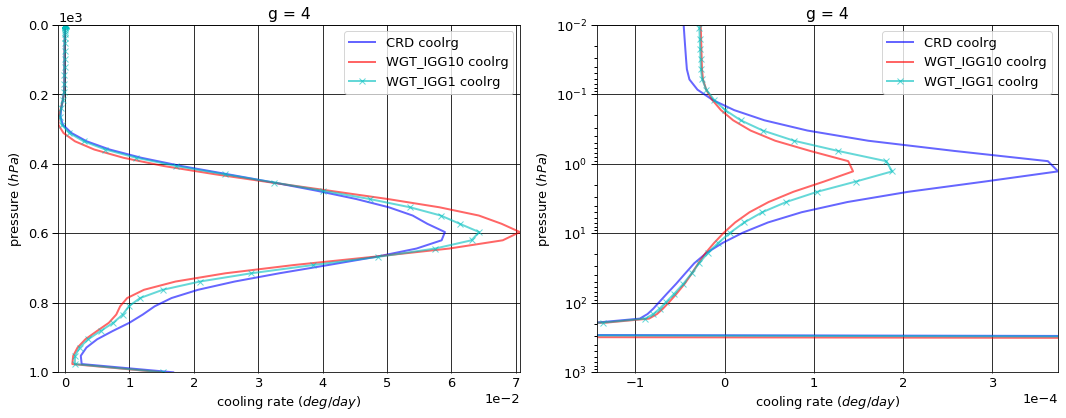

# Figure: cooling rate g-group 5

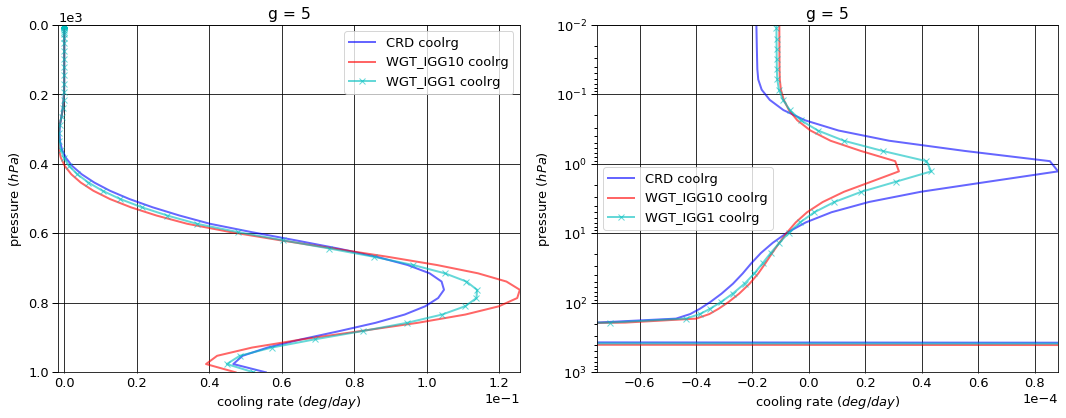

# Figure: cooling rate g-group 6

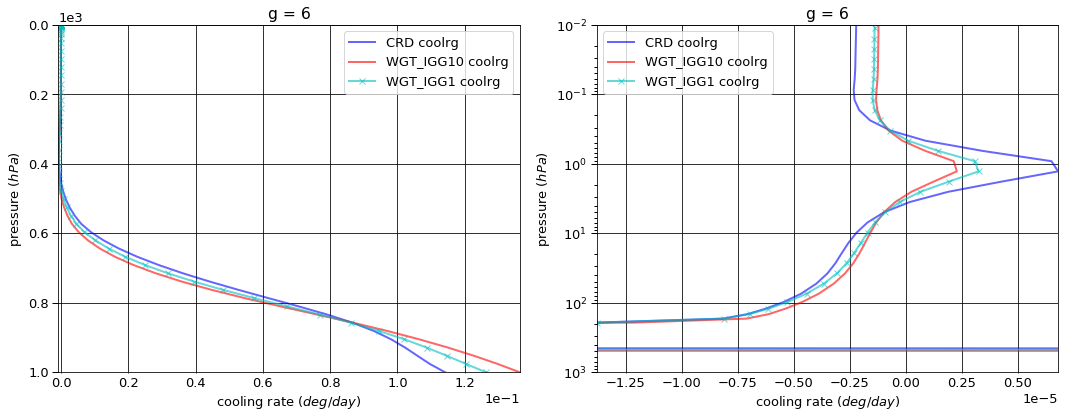

# Figure: cooling rate g-group 7

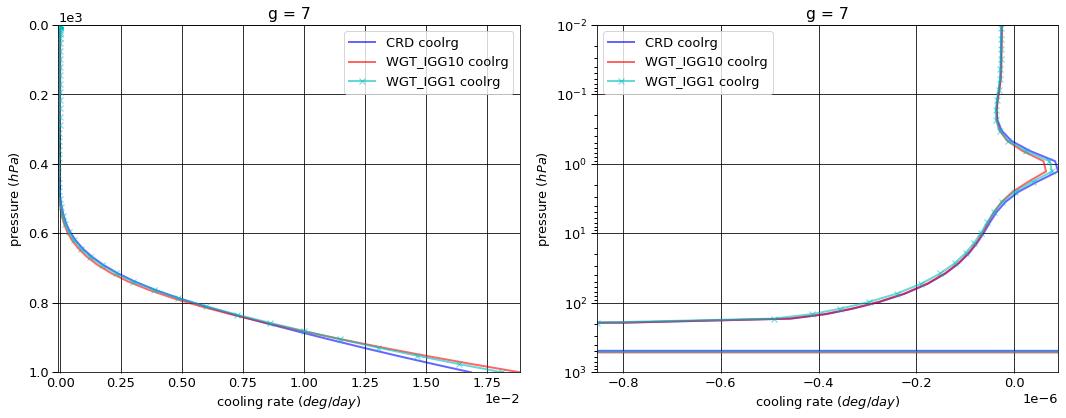

# Figure: cooling rate g-group total

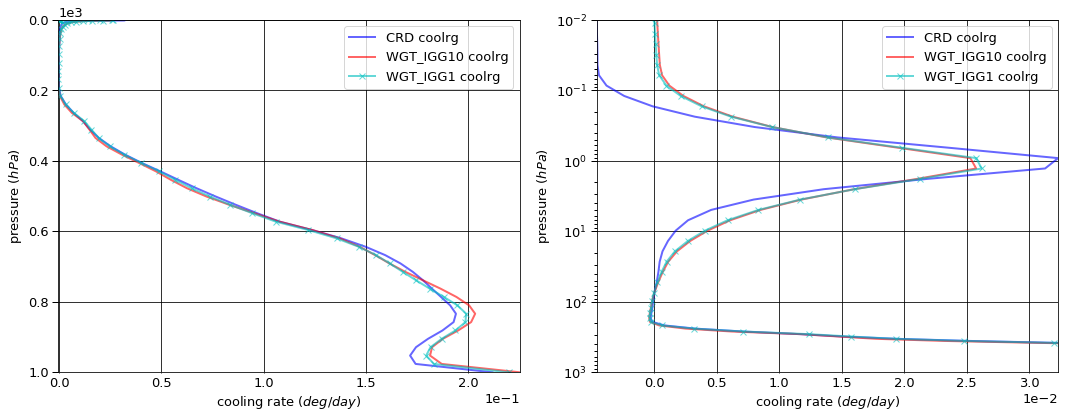

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024822  0.000000 -0.024822
  1013.0   76    -0.168537  0.166975 -0.001561
2 0.0      1     -0.131465  0.000000 -0.131465
  1013.0   76    -0.661844  0.655792 -0.006052
3 0.0      1     -0.550686  0.000000 -0.550686
  1013.0   76    -1.811400  1.794961 -0.016439
4 0.0      1     -2.226800  0.000000 -2.226800
  1013.0   76    -4.746419  4.696204 -0.050215
5 0.0      1     -4.737060  0.000000 -4.737060
  1013.0   76    -7.043324  6.669891 -0.373433
6 0.0      1     -6.317119  0.000000 -6.317119
  1013.0   76    -7.140427  4.077256 -3.063171
7 0.0      1     -2.121058  0.000000 -2.121058
  1013.0   76    -2.183224  0.399853 -1.783371


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.024627  0.000000 -0.024627
  1013.0   76    -0.158845  0.157447 -0.001399
2 0.0      1     -0.127583  0.000000 -0.127583
  1013.0   76    -0.633463  0.627885 -0.005578
3 0.0      1     -0.536865  0.000000 -0.536865
  1013.0   76    -1.750088  1.734678 -0.015410
4 0.0      1     -2.182393  0.000000 -2.182393
  1013.0   76    -4.604108  4.562118 -0.041990
5 0.0      1     -4.757027  0.000000 -4.757027
  1013.0   76    -6.999481  6.779438 -0.220043
6 0.0      1     -6.581308  0.000000 -6.581308
  1013.0   76    -7.316887  4.008275 -3.308611
7 0.0      1     -2.228544  0.000000 -2.228544
  1013.0   76    -2.292303  0.412362 -1.879941


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.025169  0.000000 -0.025169
  1013.0   76    -0.158845  0.157447 -0.001399
2 0.0      1     -0.127711  0.000000 -0.127711
  1013.0   76    -0.633463  0.627885 -0.005578
3 0.0      1     -0.537076  0.000000 -0.537076
  1013.0   76    -1.750088  1.734678 -0.015410
4 0.0      1     -2.178491  0.000000 -2.178491
  1013.0   76    -4.604108  4.560834 -0.043275
5 0.0      1     -4.739416  0.000000 -4.739416
  1013.0   76    -6.999481  6.730392 -0.269089
6 0.0      1     -6.526388  0.000000 -6.526388
  1013.0   76    -7.316887  4.041334 -3.275552
7 0.0      1     -2.225787  0.000000 -2.225787
  1013.0   76    -2.292303  0.415905 -1.876398


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000195  0.000000  0.000195
  1013.0   76     0.009691 -0.009528  0.000163
2 0.0      1      0.003882  0.000000  0.003882
  1013.0   76     0.028381 -0.027907  0.000475
3 0.0      1      0.013820  0.000000  0.013820
  1013.0   76     0.061313 -0.060283  0.001030
4 0.0      1      0.044408  0.000000  0.044408
  1013.0   76     0.142311 -0.134086  0.008225
5 0.0      1     -0.019967  0.000000 -0.019967
  1013.0   76     0.043843  0.109548  0.153390
6 0.0      1     -0.264189  0.000000 -0.264189
  1013.0   76    -0.176459 -0.068981 -0.245440
7 0.0      1     -0.107486  0.000000 -0.107486
  1013.0   76    -0.109079  0.012509 -0.096569


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000347  0.000000 -0.000347
  1013.0   76     0.009691 -0.009528  0.000163
2 0.0      1      0.003754  0.000000  0.003754
  1013.0   76     0.028381 -0.027907  0.000475
3 0.0      1      0.013609  0.000000  0.013609
  1013.0   76     0.061313 -0.060283  0.001030
4 0.0      1      0.048310  0.000000  0.048310
  1013.0   76     0.142311 -0.135370  0.006941
5 0.0      1     -0.002356  0.000000 -0.002356
  1013.0   76     0.043843  0.060502  0.104344
6 0.0      1     -0.209269  0.000000 -0.209269
  1013.0   76    -0.176459 -0.035922 -0.212381
7 0.0      1     -0.104728  0.000000 -0.104728
  1013.0   76    -0.109079  0.016052 -0.093027

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.348661e-03
  1001.112500 75     5.568332e-04
2 0.000312    1     -3.791335e-04
  1001.112500 75     2.159394e-03
3 0.000312    1     -5.999946e-05
  1001.112500 75     5.866089e-03
4 0.000312    1     -5.139942e-05
  1001.112500 75     1.679992e-02
5 0.000312    1     -1.894204e-05
  1001.112500 75     5.559944e-02
6 0.000312    1     -2.110481e-06
  1001.112500 75     1.141740e-01
7 0.000312    1     -2.345192e-08
  1001.112500 75     1.685351e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      3.959282e-05
  1001.112500 75     4.995066e-04
2 0.000312    1     -4.789336e-05
  1001.112500 75     1.991991e-03
3 0.000312    1     -4.363239e-05
  1001.112500 75     5.503337e-03
4 0.000312    1     -2.885869e-05
  1001.112500 75     1.494420e-02
5 0.000312    1     -1.052749e-05
  1001.112500 75     4.724945e-02
6 0.000312    1     -1.148856e-06
  1001.112500 75     1.363537e-01
7 0.000312    1     -2.230514e-08
  1001.112500 75     1.886399e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.811422e-04
  1001.112500 75     4.995066e-04
2 0.000312    1     -3.921870e-05
  1001.112500 75     1.991991e-03
3 0.000312    1     -4.475345e-05
  1001.112500 75     5.503337e-03
4 0.000312    1     -3.114581e-05
  1001.112500 75     1.524291e-02
5 0.000312    1     -1.165473e-05
  1001.112500 75     5.219356e-02
6 0.000312    1     -1.319071e-06
  1001.112500 75     1.262989e-01
7 0.000312    1     -2.386020e-08
  1001.112500 75     1.814032e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.388254e-03
  1001.112500 75    -5.732664e-05
2 0.000312    1      3.312402e-04
  1001.112500 75    -1.674036e-04
3 0.000312    1      1.636707e-05
  1001.112500 75    -3.627513e-04
4 0.000312    1      2.254073e-05
  1001.112500 75    -1.855724e-03
5 0.000312    1      8.414556e-06
  1001.112500 75    -8.349987e-03
6 0.000312    1      9.616248e-07
  1001.112500 75     2.217970e-02
7 0.000312    1      1.146778e-09
  1001.112500 75     2.010473e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.167519e-03
  1001.112500 75    -5.732664e-05
2 0.000312    1      3.399148e-04
  1001.112500 75    -1.674036e-04
3 0.000312    1      1.524601e-05
  1001.112500 75    -3.627513e-04
4 0.000312    1      2.025361e-05
  1001.112500 75    -1.557013e-03
5 0.000312    1      7.287315e-06
  1001.112500 75    -3.405875e-03
6 0.000312    1      7.914093e-07
  1001.112500 75     1.212492e-02
7 0.000312    1     -4.082770e-10
  1001.112500 75     1.286804e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.109011,0.000000,-16.109011
1013.0,76,-23.755175,18.460932,-5.294244



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.438347,0.000000,-16.438347
1013.0,76,-23.755175,18.282204,-5.472972



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.360037,0.000000,-16.360037
1013.0,76,-23.755175,18.268475,-5.486700



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.293364e-01,0.000000,-0.329336
1013.0,76,-2.000000e-08,-0.178728,-0.178728



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.510265e-01,0.000000,-0.251026
1013.0,76,-2.000000e-08,-0.192457,-0.192457


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.004860
1001.112500,75,0.212009



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000092
1001.112500,75,0.225406



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000309
1001.112500,75,0.219871



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.004768
1001.112500,75,0.013397



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.004551
1001.112500,75,0.007861


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008424,0.006687
2,0.031636,0.026666
3,0.084424,0.073672
4,0.218545,0.193815
5,0.300909,0.294651
6,0.277394,0.308012
7,0.078667,0.096497


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.694881e-20
2,2.526252e-21
3,3.765425e-22
4,5.612436e-23
5,8.365440e-24
6,1.246884e-24
7,1.858504e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.694881e-20,NaN,0.008424,0.006687,0.008424,0.006687,600.0
2,2.526252e-21,0.149052,0.031636,0.026666,0.040061,0.033353,600.0
3,3.765425e-22,0.149052,0.084424,0.073672,0.124485,0.107025,600.0
4,5.612436e-23,0.149052,0.218545,0.193815,0.343030,0.300840,600.0
5,8.365440e-24,0.149052,0.300909,0.294651,0.643939,0.595491,600.0
6,1.246884e-24,0.149052,0.277394,0.308012,0.921333,0.903503,600.0
7,1.858504e-25,0.149052,0.078667,0.096497,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
